In [50]:
import os, json, pathlib, warnings
from datetime import datetime, UTC

import numpy as np
import pandas as pd

from pathlib import Path
from joblib import dump, load

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, log_loss,
    precision_recall_curve, roc_curve, confusion_matrix,
    balanced_accuracy_score, f1_score, precision_score, recall_score
)

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

warnings.filterwarnings("ignore", category=FutureWarning)

RNG = 42
np.random.seed(RNG)

DATA_DIR = Path("data")
ART_DIR  = Path("artifacts")
FIG_DIR  = Path("reports/figures")
REPORTS_DIR = Path("reports")
for p in [DATA_DIR, ART_DIR, FIG_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)


In [51]:
sf_path = DATA_DIR / "storage_format.json"
fmt = "csv"
if sf_path.exists():
    raw = json.loads(sf_path.read_text(encoding="utf-8"))
    recs = [raw] if isinstance(raw, dict) else ([r for r in raw if isinstance(r, dict)] if isinstance(raw, list) else [])
    if recs:
        fmt = str(recs[-1].get("format", "csv")).lower()

if fmt == "parquet" and (DATA_DIR / "df_nb02.parquet").exists():
    try:
        df = pd.read_parquet(DATA_DIR / "df_nb02.parquet")
    except Exception as e:
        print("Parquet read failed, falling back to CSV:", e)
        df = pd.read_csv(DATA_DIR / "df_nb02.csv", parse_dates=["date"])
else:
    df = pd.read_csv(DATA_DIR / "df_nb02.csv", parse_dates=["date"])

# Feature list: prefer artifacts, fallback to data
feat_path = ART_DIR / "feature_list.json"
if not feat_path.exists() and (DATA_DIR / "feature_list.json").exists():
    feat_path = DATA_DIR / "feature_list.json"
if not feat_path.exists():
    raise FileNotFoundError("feature_list.json not found in artifacts/ or data/.")

feat_cols = json.loads(feat_path.read_text(encoding="utf-8"))
feat_cols = [c for c in feat_cols if c in df.columns]  # intersect with df columns

# Optional label params
lp = DATA_DIR / "label_params.json"
TAU = DEAD_ZONE = None
if lp.exists():
    lpj = json.loads(lp.read_text(encoding="utf-8"))
    TAU = lpj.get("tau", None)
    DEAD_ZONE = lpj.get("dead_zone", None)

print("Rows/Features:", len(df), "/", len(feat_cols), "| fmt:", fmt)
display(df[["date"] + feat_cols[: min(5, len(feat_cols))]].head())


Rows/Features: 2686 / 16 | fmt: csv


,date,close,high,low,macd,macd_signal
0,2015-02-06,26.495501,26.789573,26.388564,0.616322,0.436495
1,2015-02-09,26.671507,26.698240,26.384117,0.633757,0.475947
2,2015-02-10,27.183905,27.212867,26.769531,0.681070,0.516972
3,2015-02-11,27.821064,27.829975,27.290843,0.761204,0.565818
4,2015-02-12,28.173059,28.400298,27.974783,0.843393,0.621333


In [52]:
label_candidates = ["y", "target", "label", "y_next_up"]
label_col = next((c for c in label_candidates if c in df.columns), None)

if label_col is None:
    if "ret1" in df.columns:
        df["y"] = (df["ret1"].shift(-1) > 0).astype(int)
    else:
        price_col = next((c for c in ["close", "Close", "Adj Close", "adj_close"] if c in df.columns), None)
        if price_col is None:
            raise RuntimeError("No label column and no price/return to derive it from.")
        ret1 = pd.Series(df[price_col]).pct_change()
        df["y"] = (ret1.shift(-1) > 0).astype(int)
    df = df.dropna(subset=["y"]).copy()
    label_col = "y"
elif label_col != "y":
    df["y"] = df[label_col].astype(int)

drop_feats = {"y","target","label","y_next_up","date","ticker","symbol"}
feat_cols = [c for c in feat_cols if c in df.columns and c not in drop_feats]
feat_cols = [c for c in feat_cols if pd.api.types.is_numeric_dtype(df[c])]

df = df.sort_values("date").reset_index(drop=True)
n = len(df)
n_train = int(0.6 * n)
n_val   = int(0.2 * n)
n_test  = n - n_train - n_val

df_tr = df.iloc[:n_train].copy()
df_va = df.iloc[n_train:n_train+n_val].copy()
df_te = df.iloc[n_train+n_val:].copy()

X_tr, y_tr = df_tr[feat_cols].to_numpy(), df_tr["y"].to_numpy()
X_va, y_va = df_va[feat_cols].to_numpy(), df_va["y"].to_numpy()
X_te, y_te = df_te[feat_cols].to_numpy(), df_te["y"].to_numpy()

scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_va_s = scaler.transform(X_va)
X_te_s = scaler.transform(X_te)

print("Features:", len(feat_cols))
print("Splits:", df_tr.shape, df_va.shape, df_te.shape)
print("Label balance (train/val/test):",
      round(float(y_tr.mean()),3), round(float(y_va.mean()),3), round(float(y_te.mean()),3))


Features: 16
Splits: (1611, 22) (537, 22) (538, 22)
Label balance (train/val/test): 0.529 0.514 0.548


In [53]:
lr = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=RNG)
lr.fit(X_tr_s, y_tr)

if HAVE_XGB:
    xgb = XGBClassifier(
        n_estimators=300, max_depth=3, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective="binary:logistic", random_state=RNG, eval_metric="logloss", n_jobs=0
    )
    xgb.fit(X_tr, y_tr)  # often do NOT standardize for trees
else:
    xgb = None

print("Trained LR", "| XGB:", HAVE_XGB)


Trained LR | XGB: True


In [54]:
def metric_block(y_true, y_prob):
    p = np.clip(np.asarray(y_prob), 1e-15, 1-1e-15)
    return {
        "AUC": roc_auc_score(y_true, p),
        "PR_AUC": average_precision_score(y_true, p),
        "Brier": brier_score_loss(y_true, p),
        "LogLoss": log_loss(y_true, p)
    }

preds = {
    "LR": {
        "va": lr.predict_proba(X_va_s)[:,1],
        "te": lr.predict_proba(X_te_s)[:,1],
    }
}
if HAVE_XGB:
    preds["XGB"] = {
        "va": xgb.predict_proba(X_va)[:,1],
        "te": xgb.predict_proba(X_te)[:,1],
    }

rows = []
for name, d in preds.items():
    rows.append({"model": name, "split": "val",  **metric_block(y_va, d["va"]), "PosRate": float(y_va.mean())})
    rows.append({"model": name, "split": "test", **metric_block(y_te, d["te"]), "PosRate": float(y_te.mean())})
summary = pd.DataFrame(rows)
summary.to_csv(DATA_DIR / "explainability_summary.csv", index=False)
display(summary)


,model,split,AUC,PR_AUC,Brier,LogLoss,PosRate
0,LR,val,0.458257,0.488295,0.261855,0.718123,0.513966
1,LR,test,0.478998,0.520235,0.254662,0.702503,0.548327
2,XGB,val,0.511328,0.528512,0.277136,0.758238,0.513966
3,XGB,test,0.474534,0.522771,0.287053,0.775793,0.548327


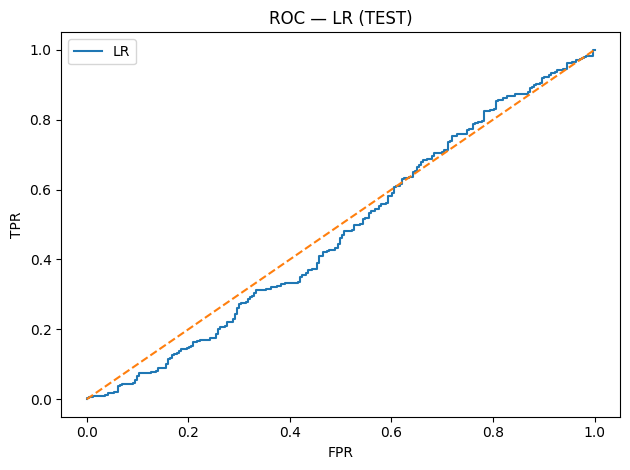

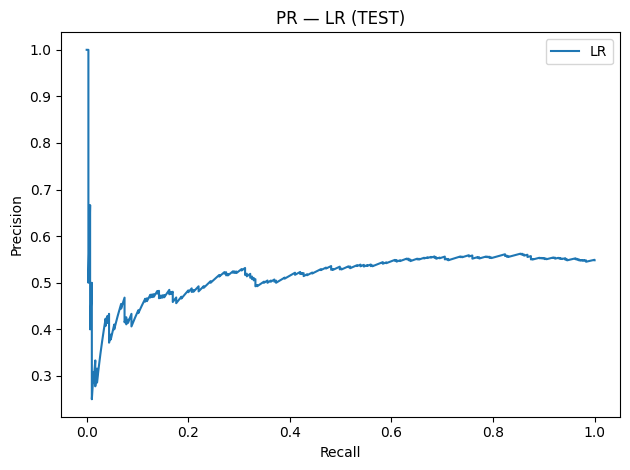

In [55]:
fpr_lr, tpr_lr, _ = roc_curve(y_te, preds["LR"]["te"])
prec_lr, rec_lr, _ = precision_recall_curve(y_te, preds["LR"]["te"])

plt.figure()
plt.plot(fpr_lr, tpr_lr, label="LR")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — LR (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_nb05.png", dpi=140)
plt.show()

plt.figure()
plt.plot(rec_lr, prec_lr, label="LR")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — LR (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "pr_nb05.png", dpi=140)
plt.show()


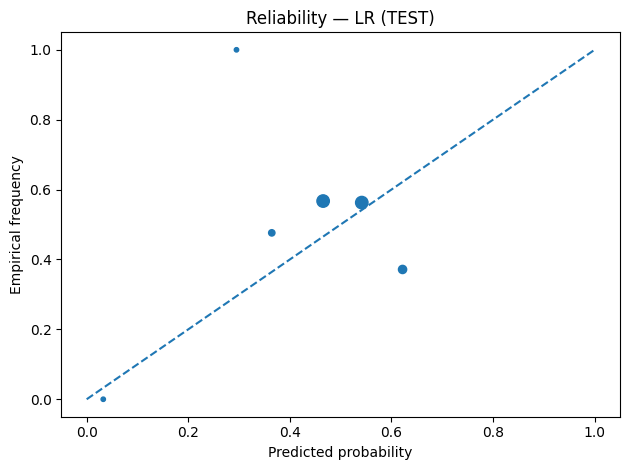

Brier (LR):  0.254662
Brier (XGB): 0.287053


In [56]:
bins = np.linspace(0,1,11)
binned = pd.cut(preds["LR"]["te"], bins=bins, include_lowest=True)
cal = df_te.assign(prob=preds["LR"]["te"]).groupby(binned, observed=False).agg(
    mean_prob=("prob","mean"), mean_true=("y","mean"), count=("y","size")
).dropna()

plt.figure()
plt.plot([0,1],[0,1], linestyle="--")
plt.scatter(cal["mean_prob"], cal["mean_true"], s=np.clip(cal["count"], 10, 80))
plt.xlabel("Predicted probability"); plt.ylabel("Empirical frequency")
plt.title("Reliability — LR (TEST)")
plt.tight_layout()
plt.savefig(FIG_DIR / "reliability_lr_nb05.png", dpi=140)
plt.show()

print("Brier (LR): ", round(float(brier_score_loss(y_te, preds["LR"]["te"])), 6))
if HAVE_XGB:
    print("Brier (XGB):", round(float(brier_score_loss(y_te, preds["XGB"]["te"])), 6))


In [57]:
from sklearn.metrics import matthews_corrcoef  # import here to avoid cross-cell dependency

# Use NB5's own splits/arrays to avoid collisions
y_va_nb5 = df_va["y"].to_numpy().astype(int)
y_te_nb5 = df_te["y"].to_numpy().astype(int)
p_va_nb5 = preds["LR"]["va"]
p_te_nb5 = preds["LR"]["te"]

# Youden J from ROC
fpr, tpr, thr = roc_curve(y_va_nb5, p_va_nb5)
t_j = float(thr[(tpr - fpr).argmax()])

# MCC and F1 on a grid
grid = np.linspace(0.05, 0.95, 181)
mcc_vals = [matthews_corrcoef(y_va_nb5, (p_va_nb5 >= t).astype(int)) for t in grid]
f1_vals  = [f1_score(y_va_nb5, (p_va_nb5 >= t).astype(int)) for t in grid]
t_mcc = float(grid[int(np.argmax(mcc_vals))])
t_f1  = float(grid[int(np.argmax(f1_vals))])

# Choose default threshold (switch to t_mcc if you prefer)
t_star = float(t_j)
print(f"Youden J thr={t_j:.3f} | MCC thr={t_mcc:.3f} | F1 thr={t_f1:.3f}")
print("Using t_star =", round(t_star, 3))

# Evaluate on TEST at chosen threshold
def eval_at(y_true, p, t):
    yhat = (p >= t).astype(int)
    return {
        "thr": round(float(t),3),
        "BalAcc": balanced_accuracy_score(y_true, yhat),
        "F1": f1_score(y_true, yhat, zero_division=0),
        "Prec": precision_score(y_true, yhat, zero_division=0),
        "Rec": recall_score(y_true, yhat, zero_division=0),
        "CM": confusion_matrix(y_true, yhat).tolist()
    }

print("TEST @ Youden J:", eval_at(y_te_nb5, p_te_nb5, t_j))
print("TEST @ MCC     :", eval_at(y_te_nb5, p_te_nb5, t_mcc))
print("TEST @ F1      :", eval_at(y_te_nb5, p_te_nb5, t_f1))

# Save the chosen threshold to artifacts
(ART_DIR / "threshold.json").write_text(
    json.dumps({"threshold": float(t_star), "policy": "YoudenJ", "computed_on": "val"}, indent=2),
    encoding="utf-8"
)
print("Saved threshold →", ART_DIR / "threshold.json")

# Also save confusion matrix @ chosen threshold
cm = confusion_matrix(y_te_nb5, (p_te_nb5 >= t_star).astype(int))
pd.DataFrame(cm, index=pd.Index([0,1], name="Actual"),
                columns=pd.Index([0,1], name="Pred")).to_csv(DATA_DIR / "confusion_matrix_LR.csv")


Youden J thr=0.447 | MCC thr=0.755 | F1 thr=0.050
Using t_star = 0.447
TEST @ Youden J: {'thr': 0.447, 'BalAcc': 0.5031317569923973, 'F1': 0.675392670157068, 'Prec': 0.5501066098081023, 'Rec': 0.8745762711864407, 'CM': [[32, 211], [37, 258]]}
TEST @ MCC     : {'thr': 0.755, 'BalAcc': 0.5, 'F1': 0.0, 'Prec': 0.0, 'Rec': 0.0, 'CM': [[243, 0], [295, 0]]}
TEST @ F1      : {'thr': 0.05, 'BalAcc': 0.5020576131687243, 'F1': 0.7091346153846154, 'Prec': 0.5493482309124768, 'Rec': 1.0, 'CM': [[1, 242], [0, 295]]}
Saved threshold → artifacts\threshold.json


In [58]:
df_te_eval = df_te.copy()
df_te_eval["prob_lr"] = p_te_nb5
df_te_eval["year"] = pd.to_datetime(df_te_eval["date"]).dt.year

by_year = df_te_eval.groupby("year").apply(
    lambda g: pd.Series({
        "AUC": roc_auc_score(g["y"], g["prob_lr"]) if g["y"].nunique() > 1 else np.nan,
        "Brier": brier_score_loss(g["y"], g["prob_lr"]),
        "PosRate": float(g["y"].mean())
    })
).reset_index()
by_year.to_csv(DATA_DIR / "metrics_by_year_LR.csv", index=False)
display(by_year.head(10))


,year,AUC,Brier,PosRate
0,2023,0.487663,0.252025,0.576087
1,2024,0.530858,0.248192,0.563492
2,2025,0.410638,0.264317,0.515464


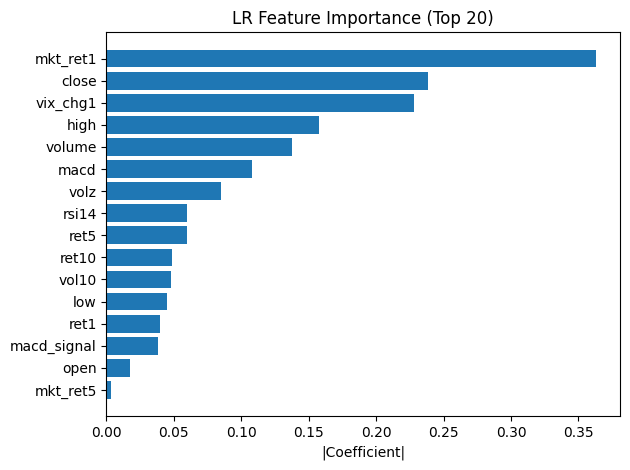

In [59]:
coef = pd.Series(lr.coef_.ravel(), index=feat_cols).sort_values(key=np.abs, ascending=False)
imp_tbl = (pd.DataFrame({"feature": coef.index, "coef": coef.values})
             .assign(abs_coef=lambda d: d["coef"].abs()))
imp_tbl.to_csv(DATA_DIR / "lr_feature_importance.csv", index=False)

topk = imp_tbl.head(20).reset_index(drop=True)
topk.to_csv(DATA_DIR / "lr_importance_topk.csv", index=False)

plt.figure()
plt.barh(topk["feature"][::-1], topk["abs_coef"][::-1])
plt.xlabel("|Coefficient|")
plt.title("LR Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig(FIG_DIR / "lr_feature_importance_topk.png", dpi=140)
plt.show()

pd.DataFrame({"feature": coef.index, "coef": coef.values}).to_csv(DATA_DIR / "logreg_coefficients_LR.csv", index=False)


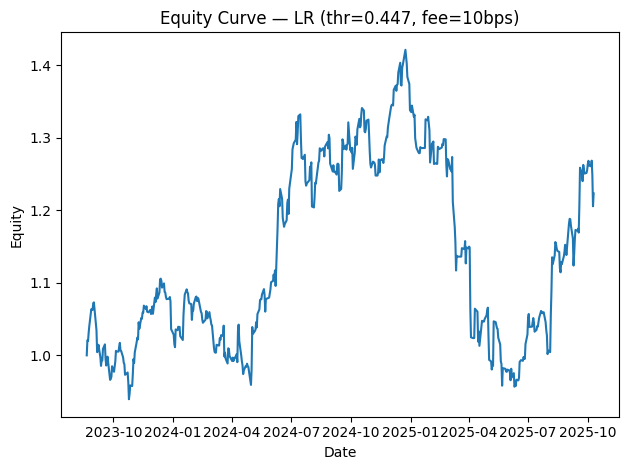

CAGR            0.0990
Vol             0.2300
Sharpe          0.4307
MaxDD          -0.3269
HitRate         0.4796
Trades        101.0000
TurnoverYr     47.3086
dtype: float64

In [60]:
FEE_BPS = 10  # one-way fee in bps (0.10%)
fee = FEE_BPS / 10000.0

df_bt = df_te_eval.copy()
if "ret_next" not in df_bt.columns:
    if "close" in df_bt.columns:
        df_bt["ret_next"] = df_bt["close"].pct_change().shift(-1)
    else:
        raise ValueError("No 'ret_next' or 'close' column found for backtest.")

signal = (df_bt["prob_lr"] >= t_star).astype(int).values
flips  = (np.abs(np.diff(np.r_[0, signal])) > 0).astype(int)  # trade when position changes
cost   = flips * fee

strat_ret = signal * df_bt["ret_next"].to_numpy() - cost
equity = (1 + pd.Series(strat_ret).fillna(0)).cumprod()

def kpis(r, flips_vec, freq=252):
    r = pd.Series(r).fillna(0)
    cagr = (1 + r).prod() ** (freq / max(len(r),1)) - 1
    vol  = r.std() * np.sqrt(freq)
    sharpe = (cagr / vol) if vol > 0 else np.nan
    eq = (1 + r).cumprod()
    maxdd = (eq / eq.cummax() - 1).min()
    hit = (r > 0).mean()
    trades = int(flips_vec.sum())
    turn_yr = flips_vec.mean() * freq
    return pd.Series({"CAGR":cagr, "Vol":vol, "Sharpe":sharpe, "MaxDD":maxdd, "HitRate":hit, "Trades":trades, "TurnoverYr":turn_yr})

bt_stats = kpis(strat_ret, flips).round(4)

plt.figure()
plt.plot(df_bt["date"], equity)
plt.title(f"Equity Curve — LR (thr={t_star:.3f}, fee={FEE_BPS}bps)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.tight_layout()
plt.savefig(FIG_DIR / "equity_curve_lr.png", dpi=140)
plt.show()

display(bt_stats)


In [61]:
dump(scaler, ART_DIR / "scaler.joblib")
dump(lr, ART_DIR / "lr.joblib")
print("Saved:", ART_DIR / "scaler.joblib", ART_DIR / "lr.joblib", ART_DIR / "threshold.json")


Saved: artifacts\scaler.joblib artifacts\lr.joblib artifacts\threshold.json


In [62]:
def df_to_md(tbl: pd.DataFrame, index=False, floatfmt=".4f"):
    df2 = tbl.copy()
    if (not index) and (df2.index.name is not None):
        df2 = df2.reset_index()
    for col in df2.columns:
        if pd.api.types.is_float_dtype(df2[col]):
            df2[col] = df2[col].map(lambda x: f"{x:{floatfmt}}" if pd.notnull(x) else "")
    headers = list(map(str, df2.columns))
    lines = ["| " + " | ".join(headers) + " |", "| " + " | ".join(["---"] * len(headers)) + " |"]
    for _, row in df2.iterrows():
        lines.append("| " + " | ".join(map(str, row.values)) + " |")
    return "\n".join(lines)

def _safe_read_csv(path, fallback_rows=None):
    p = Path(path)
    if p.exists():
        try:
            return pd.read_csv(p)
        except Exception as e:
            print(f"Warning: failed to read {path}: {e}")
    return pd.DataFrame(fallback_rows or [])

TICKER = (df["ticker"].iloc[0] if "ticker" in df.columns and len(df) else "UNK")
START  = str(pd.to_datetime(df["date"]).min().date())
END    = str(pd.to_datetime(df["date"]).max().date())

thr_obj = json.loads((ART_DIR / "threshold.json").read_text())
t_star_saved = thr_obj.get("threshold", thr_obj.get("tau", None))

card_tbl = _safe_read_csv(DATA_DIR / "explainability_summary.csv",
                          fallback_rows=[{"model":"LR","split":"test","AUC":"","PR_AUC":"","Brier":"","LogLoss":"","PosRate":""}])
by_year_tbl = _safe_read_csv(DATA_DIR / "metrics_by_year_LR.csv",
                             fallback_rows=[{"year":"","AUC":"","Brier":"","PosRate":""}])

feat_preview = ", ".join(feat_cols[:12]) + (" ..." if len(feat_cols) > 12 else "")
today_utc = datetime.now(UTC).date().isoformat()
labeling_str = f"tau={TAU}, dead_zone={DEAD_ZONE}" if (TAU is not None) else "from earlier settings"

card = f"""# Model Card — Stock Direction (LogReg)
**Date:** {today_utc}  
**Ticker:** {TICKER} | **Period:** {START} → {END}  
**Labeling:** {labeling_str}  
**Features ({len(feat_cols)}):** {feat_preview}

## Metrics (Val/Test summary)
{df_to_md(card_tbl, index=False, floatfmt=".4f")}

**Chosen threshold (val-based):** {t_star_saved:.3f}

## Stability (Test by year)
{df_to_md(by_year_tbl, index=False, floatfmt=".4f")}

## Backtest (Test set, long-only @ threshold)
{df_to_md(pd.DataFrame([bt_stats]), index=False, floatfmt=".4f")}

## Artifacts
- `artifacts/scaler.joblib`, `artifacts/lr.joblib`, `artifacts/threshold.json`, `artifacts/feature_list.json`
- Curves: `reports/figures/roc_nb05.png`, `pr_nb05.png`, `reliability_lr_nb05.png`, `equity_curve_lr.png`
- Importance: `reports/figures/lr_feature_importance_topk.png`
"""
(REPORTS_DIR / "model_card.md").write_text(card, encoding="utf-8")
print("Wrote", REPORTS_DIR / "model_card.md")


Wrote reports\model_card.md


In [63]:
# ----- Cell 14: Quick output checklist -----
print("Artifacts:", list(ART_DIR.glob("*")))
print("Figures:",  list(FIG_DIR.glob("*.png")))
print("Data:",     [p for p in DATA_DIR.glob("*") if p.suffix in {'.csv','.parquet','.json'}])


Artifacts: [WindowsPath('artifacts/backtest_summary.json'), WindowsPath('artifacts/feature_list.json'), WindowsPath('artifacts/inversion.json'), WindowsPath('artifacts/lr.joblib'), WindowsPath('artifacts/lstm_nb3.pt'), WindowsPath('artifacts/lstm_scaler.joblib'), WindowsPath('artifacts/nb3_lstm_config.json'), WindowsPath('artifacts/nb3_split_info.json'), WindowsPath('artifacts/scaler.joblib'), WindowsPath('artifacts/test_target_dates.npy'), WindowsPath('artifacts/threshold.json'), WindowsPath('artifacts/train_target_dates.npy'), WindowsPath('artifacts/val_target_dates.npy'), WindowsPath('artifacts/walkforward_summary.json'), WindowsPath('artifacts/wf_backtest_summary.json')]
Figures: [WindowsPath('reports/figures/eda_close.png'), WindowsPath('reports/figures/eda_ret1_hist.png'), WindowsPath('reports/figures/equity_curve_lr.png'), WindowsPath('reports/figures/equity_curve_vs_buyhold.png'), WindowsPath('reports/figures/equity_curve_walkforward.png'), WindowsPath('reports/figures/lr_featu